In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import InceptionV3, ResNet50, VGG16
import time
from tqdm.notebook import tqdm


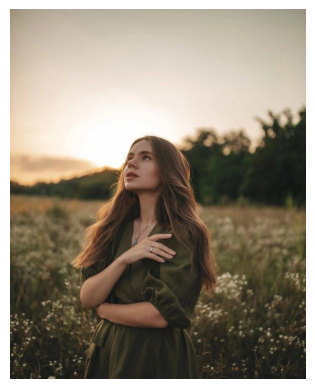

In [63]:
# Load the base image
base_image_path = keras.utils.get_file(
    "img_2.jpg", origin="https://i.pinimg.com/736x/1d/9f/f2/1d9ff2e93f8c5a439820e89bdb46d606.jpg"
)

# Display the base image
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))
plt.show()

In [64]:
models = {
    "InceptionV3": {
        "model": InceptionV3(weights="imagenet", include_top=False),
        "preprocess": keras.applications.inception_v3.preprocess_input
    },
    "MobileNetV2": {
        "model": keras.applications.MobileNetV2(weights="imagenet", include_top=False),
        "preprocess": keras.applications.mobilenet_v2.preprocess_input
    },
    "ResNet50": {
        "model": ResNet50(weights="imagenet", include_top=False),
        "preprocess": keras.applications.resnet50.preprocess_input
    },
}

<ipython-input-64-ea725a94be72>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  "model": keras.applications.MobileNetV2(weights="imagenet", include_top=False),


In [65]:
# 3. Load and Preprocess Image
def preprocess_image(image_path, preprocess_fn):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_fn(img)
    return tf.convert_to_tensor(img)

def deprocess_image(img):
    img = img.numpy()
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img


In [66]:
layer_settings = {
    "InceptionV3": {
        "mixed3": 0.8,
        "mixed4": 1.2,
        "mixed5": 1.6,
        "mixed6": 2.0,
        "mixed7": 2.4,
        "mixed8": 2.8,
        "mixed9": 3.2,
        "mixed10": 3.6,
    },
    "ResNet50": {
        "conv3_block4_out": 0.7,
        "conv4_block1_out": 1.0,
        "conv4_block6_out": 1.4,
        "conv5_block1_out": 1.8,
        "conv5_block3_out": 2.2,
        "conv5_block4_out": 2.6,
    },
    "VGG16": {
        "block1_conv2": 0.5,
        "block2_conv2": 0.8,
        "block3_conv3": 1.2,
        "block4_conv3": 1.6,
        "block5_conv2": 2.0,
        "block5_conv3": 2.4,
    },
    "MobileNetV2": {
        "block_6_expand": 0.8,
        "block_11_project": 1.2,
        "block_13_expand": 1.6,
        "block_15_project": 2.0,
        "Conv_1_relu": 2.4,
    },
    "EfficientNetB0": {
        "block2a_activation": 0.8,
        "block3a_expand_activation": 1.2,
        "block4a_expand_activation": 1.6,
        "block5a_expand_activation": 2.0,
        "block6a_expand_activation": 2.4,
        "top_activation": 2.8,
    }
}

In [67]:
def create_feature_extractor(model, layer_settings):
    outputs_dict = {
        layer.name: layer.output
        for layer in model.layers if layer.name in layer_settings
    }
    return keras.Model(inputs=model.input, outputs=outputs_dict)

# feature_extractors = {
#     model_name: create_feature_extractor(model, layer_settings[model_name])
#     for model_name, model in models.items()
# }


In [68]:
def compute_loss(input_image, feature_extractor, layer_settings):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

In [69]:
@tf.function
def gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, feature_extractor, layer_settings)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

In [70]:
def gradient_ascent_loop(image, feature_extractor, layer_settings, iterations, learning_rate, max_loss=None):
    for i in tqdm(range(iterations), desc="Processing Image"):
        loss, image = gradient_ascent_step(image, feature_extractor, learning_rate, layer_settings)
        if max_loss is not None and loss > max_loss:
            break
        if i % 5 == 0:
            print(f"... Loss at step {i}: {loss:.2f}")
    return image

In [71]:
def apply_deepdream(model_name, image, feature_extractor, layer_settings, learning_rate=0.1, iterations=20, max_loss=15):
    img = tf.identity(image)
    img = gradient_ascent_loop(img, feature_extractor, layer_settings, iterations, learning_rate, max_loss)
    return deprocess_image(img)


# Load and preprocess image separately for each model
deepdream_images = {}
feature_extractors = {}
model_image = {}

for model_name, model_info in models.items():
    print(f"\nApplying DeepDream using {model_name}...")
    model = model_info["model"]
    preprocess_fn = model_info["preprocess"]

    # Preprocess image with the correct function
    model_img = preprocess_image(base_image_path, preprocess_fn)
    model_image[model_name] = model_img

    # Create feature extractor for the current model
    feature_extractor = create_feature_extractor(model, layer_settings[model_name])
    feature_extractors[model_name] = feature_extractor

    # Run DeepDream and store output
    deepdream_images[model_name] = apply_deepdream(
        model_name, model_img, feature_extractor, layer_settings[model_name]
    )

# # Run DeepDream on all three models and visualize
# deepdream_images = {}
# for model_name in models:
#     print(f"\n🌈 Applying DeepDream using {model_name}...")
#     deepdream_images[model_name] = apply_deepdream(
#         model_name, original_img, feature_extractors[model_name], layer_settings[model_name]
#     )


Applying DeepDream using InceptionV3...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 2.60
... Loss at step 5: 3.49
... Loss at step 10: 4.30
... Loss at step 15: 5.10

Applying DeepDream using MobileNetV2...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 12.34
... Loss at step 5: 12.92
... Loss at step 10: 13.52
... Loss at step 15: 14.13

Applying DeepDream using ResNet50...


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 8.33
... Loss at step 5: 8.34
... Loss at step 10: 8.36
... Loss at step 15: 8.37


In [72]:
original_img = model_image["InceptionV3"]

base_shape = tf.shape(original_img)[1:3].numpy()
successive_shapes = [base_shape]
for i in range(3):
    shape = tuple([int(dim / (1.4 ** i)) for dim in base_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]  # Smallest to original size

In [73]:
# Use InceptionV3 for final multiscale dreaming
feature_extractor = feature_extractors["InceptionV3"]
img = tf.identity(original_img)
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

iterations = 20
max_loss = 15.0

for i, shape in enumerate(successive_shapes):
    print(f"\nProcessing octave {i+1}/{len(successive_shapes)} with shape: {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, feature_extractor, layer_settings["InceptionV3"], iterations, 20.0, max_loss)

    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail

    shrunk_original_img = tf.image.resize(original_img, shape)


Processing octave 1/4 with shape: (459, 367)


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 4.82
... Loss at step 5: 10.21
... Loss at step 10: 13.00

Processing octave 2/4 with shape: (642, 514)


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 3.85
... Loss at step 5: 8.54
... Loss at step 10: 14.58

Processing octave 3/4 with shape: (900, 720)


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

... Loss at step 0: 4.03
... Loss at step 5: 9.74
... Loss at step 10: 14.67

Processing octave 4/4 with shape: [900 720]


Processing Image:   0%|          | 0/20 [00:00<?, ?it/s]

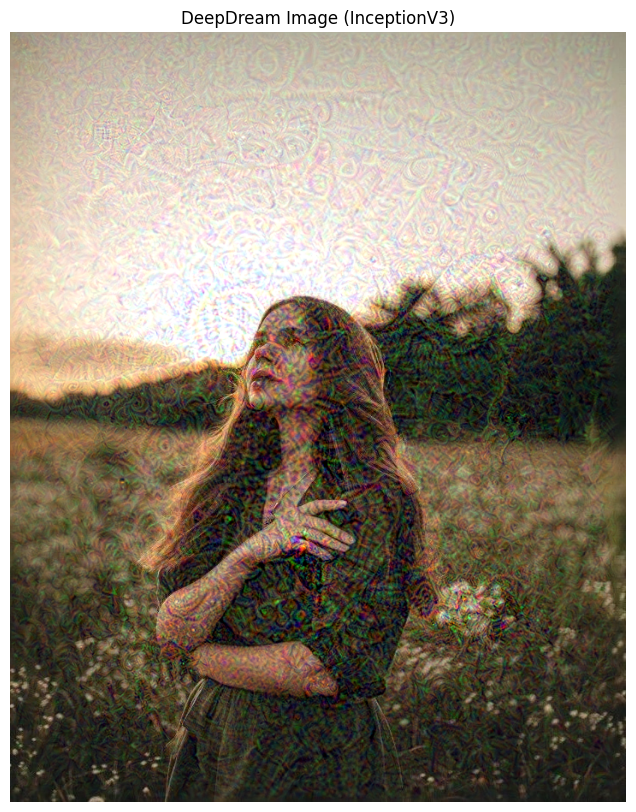

In [74]:
final_img = deprocess_image(img)
keras.utils.save_img("dream.png", final_img)
plt.figure(figsize=(10, 10))
plt.imshow(final_img)
plt.axis("off")
plt.title("DeepDream Image (InceptionV3)")
plt.show()